
# Project: Investigate Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## 1. Introduction

>In this project we will be analyzing Soccer Database from Kaggle, It contains data for soccer matches, players, and teams from several European countries from 2008 to 2016

>We will be interested in finding how are the players rated? What attributes makes a good player? how is the ratings changed over the years? what makes a successful team? what league have the most maches? how is the home team performance compared to away team?
 


<a id='wrangling'></a>
## 2. Data Wrangling


## 2.1 Data Gathering

#### 2.1.1 Importing Liberaries

In [1]:
#importing liberaries
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as et

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### 2.1.2 Connecting database

In [2]:
#connecting sql database
conn = sqlite3.connect('database.sqlite')

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables #view database tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


The database contain alot of data about betting on match score, which we will not be interested in this analysis. So we will create 3 tables with just the columns conserning teams and players performance.

#### 2.1.3 Loading data
- create teams dataframe from team, team_attribute tables with selected columns to avoid loading unnessecary data
- create matches dataframe from match, league, country tables
- create players dataframe from player , player_attribute tables

In [3]:
#creating dataframe with Teams required data and changing columns names:
teams = pd.read_sql('''SELECT ta.team_fifa_api_id, t.team_long_name AS team_name, ta.date,
                                ta.buildUpPlaySpeedClass AS speed,
                                ta.buildUpPlayDribblingClass AS dribbling,
                                ta.buildUpPlayPassingClass AS passing,
                                ta.buildUpPlayPositioningClass AS positioning,
                                ta.chanceCreationPassingClass AS chance_passing,
                                ta.chanceCreationCrossingClass AS chance_crossing,
                                ta.chanceCreationShootingClass AS chance_shooting,
                                ta.chanceCreationPositioningClass AS chance_positioning,
                                ta.defencePressureClass AS defense_pressure,
                                ta.defenceAggressionClass AS defense_aggression,
                                ta.defenceTeamWidthClass AS team_width,
                                ta.defenceDefenderLineClass AS defender_line
                            FROM Team_Attributes as ta
                            JOIN Team as t on t.team_api_id = ta.team_api_id
                                ''',
                    conn)

In [4]:
#creating dataframe with matches data:
matches = pd.read_sql('''SELECT m.id, c.name AS country, l.name AS league, m.season, m.stage, m.date,
                                ht.team_long_name AS home_team, at.team_long_name AS away_team,
                                m.home_team_goal,m.away_team_goal
                        FROM Match AS m
                        JOIN Country AS c on c.id = m.country_id
                        JOIN League AS l on l.id = m.league_id
                        LEFT JOIN Team AS HT on HT.team_api_id = m.home_team_api_id
                        LEFT JOIN Team AS AT on AT.team_api_id = m.away_team_api_id
                        ''',
                     conn)

In [5]:
#create dataframe with players data:
players = pd.read_sql('''SELECT * 
                        FROM Player_Attributes
                        LEFT JOIN Player ON player.Player_api_id = Player_Attributes.player_api_id''',
                      conn)

**Drop duplicated columns**

**Fix dtypes**

# 2.2 Data Assessing and Cleaning:
### 2.2.1 Teams Dataframe
- change dtype of categorical columns
- create year column
- remove date and id columns
- remove duplicated rows

In [6]:
teams.head(5) #view top 5 rows of teams dataframe

,team_fifa_api_id,team_name,date,speed,dribbling,passing,positioning,chance_passing,chance_crossing,chance_shooting,chance_positioning,defense_pressure,defense_aggression,team_width,defender_line
0,434,FC Aarau,2010-02-22 00:00:00,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
1,434,FC Aarau,2014-09-19 00:00:00,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
2,434,FC Aarau,2015-09-10 00:00:00,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
3,77,Aberdeen,2010-02-22 00:00:00,Fast,Little,Long,Organised,Risky,Lots,Lots,Organised,Medium,Double,Wide,Cover
4,77,Aberdeen,2011-02-22 00:00:00,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover


In [7]:
#change dtype date column to datetime:
teams['date']=pd.to_datetime(teams['date'])

# get year from date column:
teams['year']=teams['date'].dt.year

# drop date column:
teams.drop('date', axis=1, inplace=True)

In [8]:
# change dtype for categeorical columns to category:
_lis = teams.columns.tolist() #create a list of all columns names
del(_lis[1],_lis[0],_lis[-1]) #remove non-categorical columns from the list

#use for loop to change dtype for all columns in the list
for col in _lis:
    teams[col] = teams[col].astype('category') 

In [9]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   team_fifa_api_id    1458 non-null   int64   
 1   team_name           1458 non-null   object  
 2   speed               1458 non-null   category
 3   dribbling           1458 non-null   category
 4   passing             1458 non-null   category
 5   positioning         1458 non-null   category
 6   chance_passing      1458 non-null   category
 7   chance_crossing     1458 non-null   category
 8   chance_shooting     1458 non-null   category
 9   chance_positioning  1458 non-null   category
 10  defense_pressure    1458 non-null   category
 11  defense_aggression  1458 non-null   category
 12  team_width          1458 non-null   category
 13  defender_line       1458 non-null   category
 14  year                1458 non-null   int64   
dtypes: category(12), int64(2), object(1)
m

In [10]:
#check for duplicated columns
teams.duplicated().sum()

8

In [11]:
#drop duplicated columns
teams.drop_duplicates(inplace=True)

In [12]:
#how many teams in the dataframe
teams['team_name'].value_counts()

AS Monaco              6
FC Groningen           6
Tottenham Hotspur      6
Eintracht Frankfurt    6
Arsenal                6
                      ..
KAS Eupen              1
KSV Roeselare          1
FC Penafiel            1
FC Vaduz               1
SV Darmstadt 98        1
Name: team_name, Length: 285, dtype: int64

### 2.2.2 Matches Dataframe
- create new column with winner team
- create new column with year
- drop year, id columns

In [13]:
#view top 5 rows of dataframe
matches.head(5)

,id,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,KRC Genk,Beerschot AC,1,1
1,2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,SV Zulte-Waregem,Sporting Lokeren,0,0
2,3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,KSV Cercle Brugge,RSC Anderlecht,0,3
3,4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,KAA Gent,RAEC Mons,5,0
4,5,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,FCV Dender EH,Standard de Liège,1,3


In [14]:
#create column with winner team name:
#define function to check for winner team (with most goals)
def winner(home, away,_id):
    _id -= 1
    if home > away:
        return matches.iloc[_id]['home_team']
    elif away > home:
        return matches.iloc[_id]['away_team']
    else:
        return 'tie'

#create new column with winner
matches['winner']=np.vectorize(winner)(matches['home_team_goal'],matches['away_team_goal'],matches['id'])
#drop id column (no longer needed)
matches.drop('id', axis=1, inplace=True)

In [15]:
#check for duplicates
matches.duplicated().sum()

0

create new column with match year

In [16]:
#change dtype of date
matches['date']=pd.to_datetime(matches['date'])
#create column with year
matches['year']=matches['date'].dt.year
# drop date column:
matches.drop('date', axis=1, inplace=True)

In [17]:
#view sample 5 rows 
matches.sample(5)

,country,league,season,stage,home_team,away_team,home_team_goal,away_team_goal,winner,year
9834,Germany,Germany 1. Bundesliga,2014/2015,29,Bayer 04 Leverkusen,Hannover 96,4,0,Bayer 04 Leverkusen,2015
19161,Portugal,Portugal Liga ZON Sagres,2014/2015,17,CS Marítimo,SL Benfica,0,4,SL Benfica,2015
16685,Poland,Poland Ekstraklasa,2012/2013,1,Legia Warszawa,Korona Kielce,4,0,Legia Warszawa,2012
7778,France,France Ligue 1,2015/2016,7,Angers SCO,Stade de Reims,0,0,tie,2015
22539,Spain,Spain LIGA BBVA,2010/2011,33,Real Zaragoza,UD Almería,1,0,Real Zaragoza,2011


### 2.2.3 Players Dataframe
- remove duplicated columns
- create age column
- create year column
- fix values in attacking work rate and defense work rate
- drop null and None

In [18]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 49 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

create new column with player age

In [19]:
#Change dtype:
players['date']=pd.to_datetime(players['date'])
players['birthday']=pd.to_datetime(players['birthday'])
#calculate player age in new column
players['age']=players['date'].dt.year-players['birthday'].dt.year

#get year
players['year']=players['date'].dt.year

In [20]:
#calculate BMI
players['BMI'] =round((players['weight']/2.205)/((players['height']/100)**2),1)

In [21]:
#drop null
#convert None values to null
players = players.replace(to_replace='None', value=np.nan).dropna()

#drop replicated and unwanted columns
columns = ['id', 'player_fifa_api_id', 'player_api_id', 'date', 'birthday']
players.drop(columns, inplace=True, axis=1)

In [22]:
#view sample of 5 rows
players.sample(5)

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,height,weight,age,year,BMI
62216,72.0,77.0,right,medium,medium,67.0,62.0,43.0,72.0,56.0,...,11.0,11.0,11.0,7.0,Genki Haraguchi,177.80,150,24,2015,21.5
24098,65.0,74.0,left,medium,medium,60.0,57.0,43.0,67.0,64.0,...,10.0,7.0,13.0,15.0,Bruno Nazario,177.80,154,20,2015,22.1
63696,65.0,70.0,right,high,medium,63.0,64.0,58.0,64.0,45.0,...,8.0,12.0,7.0,12.0,Gianluca Frontino,175.26,161,26,2015,23.8
123783,53.0,60.0,right,medium,high,35.0,23.0,52.0,39.0,29.0,...,7.0,14.0,11.0,15.0,Michael Rose,180.34,154,21,2015,21.5
97972,64.0,71.0,right,medium,medium,53.0,67.0,65.0,63.0,57.0,...,10.0,9.0,13.0,14.0,Kristjan Gauti Emilsson,185.42,157,22,2015,20.7


In [23]:
players.defensive_work_rate.value_counts()

medium    130764
high       26972
low        18425
ormal        317
es            94
2             89
tocky         86
ean           78
1             44
6             34
5             28
4             27
3             23
0             20
9             17
7             14
8              5
Name: defensive_work_rate, dtype: int64

In [24]:
#Fixing values in defensive_work_rate
#replace low values with low
lis = ['o','0','1','2','3','4','5','6','7','8','9','ean']
players['defensive_work_rate'].replace(to_replace=lis, value='low', inplace=True)

#replace ormal (normal) with medium
players['defensive_work_rate'].replace(to_replace=['ormal','normal'], value='medium', inplace=True)

# replace es (yes) and tocky (stocky) with high
players['defensive_work_rate'].replace(to_replace=['es','tocky'], value='high', inplace=True)

players.defensive_work_rate.value_counts()

medium    131081
high       27152
low        18804
Name: defensive_work_rate, dtype: int64

In [25]:
players.attacking_work_rate.value_counts()

medium    125070
high       42823
low         8569
norm         317
y             94
stoc          86
le            78
Name: attacking_work_rate, dtype: int64

In [26]:
#Fixing values in attacking_work_rate
#replace le (lean) with low
players['attacking_work_rate'].replace(to_replace='le', value='low', inplace=True)

#replace norm (normal) with medium
players['attacking_work_rate'].replace(to_replace=['norm','normal'], value='medium', inplace=True)

# replace y (yes) and stoc (stocky) with high
players['attacking_work_rate'].replace(to_replace=['y','stoc'], value='high', inplace=True)

players.attacking_work_rate.value_counts()

medium    125387
high       43003
low         8647
Name: attacking_work_rate, dtype: int64

<a id='eda'></a>
## 3. Exploratory Data Analysis


### 3.1 Players performance:

####  What attributes makes a good player?

In [27]:
#calculate correlation between numerical attribute to player overall_rating
correlation_matrix  = players.corr()
correlation_matrix["overall_rating"].sort_values(ascending=False)

overall_rating        1.000000
reactions             0.774268
potential             0.765294
short_passing         0.458771
ball_control          0.443836
long_passing          0.435072
vision                0.431583
shot_power            0.427886
penalties             0.393190
long_shots            0.392420
age                   0.381246
positioning           0.368606
volleys               0.361331
crossing              0.357317
curve                 0.357265
dribbling             0.353402
free_kick_accuracy    0.349833
finishing             0.329220
stamina               0.325088
aggression            0.323355
strength              0.315832
heading_accuracy      0.313988
jumping               0.259005
sprint_speed          0.251603
interceptions         0.249342
acceleration          0.242819
agility               0.238903
year                  0.175781
standing_tackle       0.165458
balance               0.158602
marking               0.133045
sliding_tackle        0.129732
BMI     

In [28]:
#drop columns with low correlation (less than 0.25):
lis = ['acceleration', 'agility', 'balance', 'interceptions', 'marking' ,'standing_tackle', 'sliding_tackle' ,
       'height', 'weight', 'BMI','gk_kicking', 'gk_diving', 'gk_positioning', 'gk_reflexes', 'gk_handling']

players.drop(lis, inplace=True, axis=1)

In [29]:
#view statistics
players.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
overall_rating,177037.0,68.680248,7.034967,33.0,64.0,69.0,73.0,94.0
potential,177037.0,73.515372,6.588703,39.0,69.0,74.0,78.0,97.0
crossing,177037.0,55.211035,17.257098,1.0,45.0,59.0,68.0,95.0
finishing,177037.0,50.046736,19.029755,1.0,34.0,53.0,65.0,97.0
heading_accuracy,177037.0,57.264346,16.490296,1.0,49.0,60.0,68.0,98.0
short_passing,177037.0,62.538678,14.179399,3.0,57.0,65.0,72.0,97.0
volleys,177037.0,49.571451,18.259944,1.0,36.0,52.0,64.0,93.0
dribbling,177037.0,59.360625,17.739923,1.0,52.0,64.0,72.0,97.0
curve,177037.0,53.089942,18.261279,2.0,41.0,56.0,67.0,94.0
free_kick_accuracy,177037.0,49.433892,17.827510,1.0,36.0,50.0,64.0,97.0


- check relation between player overall rating and categorical columns

<AxesSubplot:title={'center':'players overall rating and preferred foot'}, xlabel=' player preferred foot', ylabel='player overall rating'>

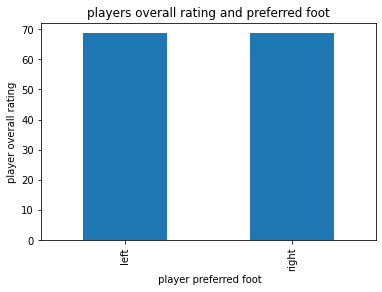

In [30]:
# plotting overall rating for players with preferred right and left foot:
players.groupby(['preferred_foot'])['overall_rating'].mean().plot(kind='bar', xlabel=' player preferred foot',
                                                                      ylabel='player overall rating',
                                                                 title='players overall rating and preferred foot')

<AxesSubplot:title={'center':'players overall rating and defensive work rate'}, xlabel=' player defensive work rate', ylabel='player overall rating'>

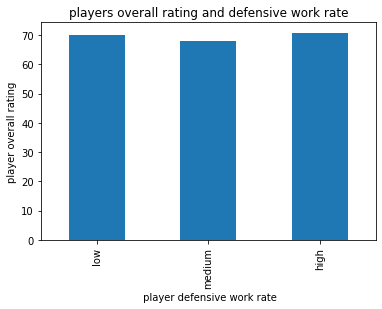

In [31]:
# plotting overall rating for players with attacking work rate and defensive work rate:
players.groupby(['defensive_work_rate'])['overall_rating'].mean().reindex(['low','medium','high']).plot(kind='bar',
                                                                                             xlabel=' player defensive work rate',
                                                                                             ylabel='player overall rating',
                                                                                            title='players overall rating and defensive work rate')

<AxesSubplot:title={'center':'players overall rating and attacking work rate'}, xlabel=' player attacking work rate', ylabel='player overall rating'>

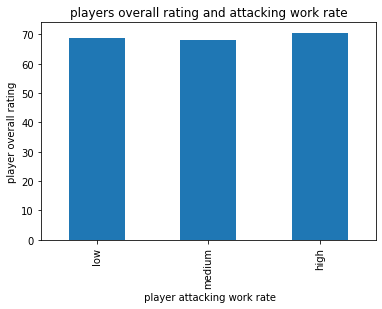

In [32]:
players.groupby(['attacking_work_rate'])['overall_rating'].mean().reindex(['low','medium','high']).plot(kind='bar',
                                                                                             xlabel=' player attacking work rate',
                                                                                             ylabel='player overall rating',
                                                                                             title='players overall rating and attacking work rate')

- Preferred foot , attacking work rate and defensive work rate have unsignificant effect on overall rating

- check relation between player overall rating and numerical attributes

Text(0.5, 0, 'Player overall Rating')

<Figure size 432x288 with 0 Axes>

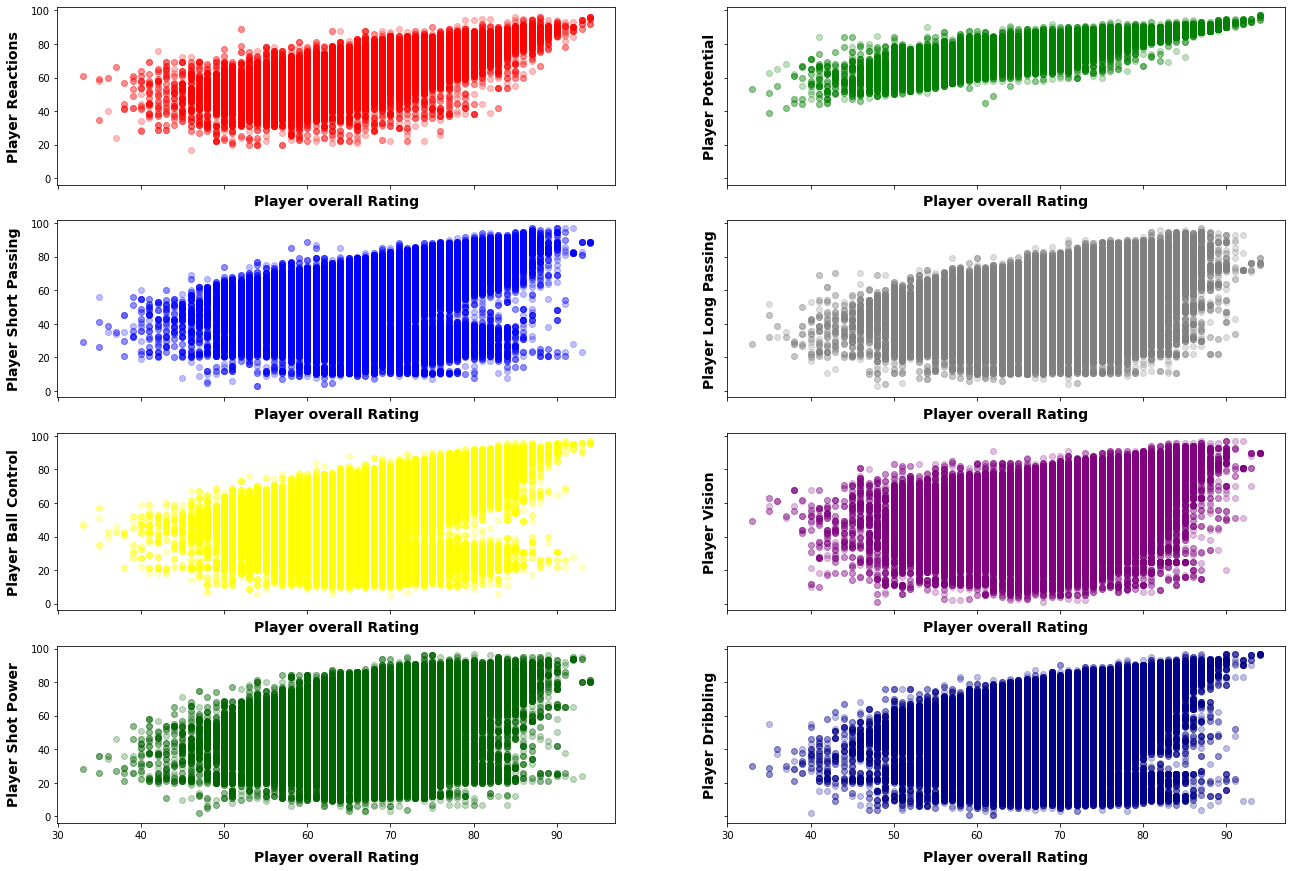

In [33]:
# plotting attributes with very high effect on player overall rating:
f = plt.figure()    
f, axes = plt.subplots(nrows = 4, ncols = 2, sharex=True, sharey = True, figsize=(22,15))


axes[0][0].scatter(players.overall_rating, players.reactions,alpha=0.25 , color='Red')
axes[0][0].set_ylabel('Player Reactions', labelpad = 10,fontsize=14, weight='bold')
axes[0][0].set_xlabel('Player overall Rating', labelpad = 10,fontsize=14, weight='bold')

axes[0][1].scatter(players.overall_rating, players.potential,alpha=0.25, color='Green')
axes[0][1].set_ylabel('Player Potential', labelpad = 10,fontsize=14, weight='bold')
axes[0][1].set_xlabel('Player overall Rating', labelpad = 10,fontsize=14, weight='bold')

axes[1][0].scatter(players.overall_rating, players.short_passing,alpha=0.25, color='Blue')
axes[1][0].set_ylabel('Player Short Passing', labelpad = 10,fontsize=14, weight='bold')
axes[1][0].set_xlabel('Player overall Rating', labelpad = 10,fontsize=14, weight='bold')

axes[1][1].scatter(players.overall_rating, players.long_passing,alpha=0.25, color='Gray')
axes[1][1].set_ylabel('Player Long Passing', labelpad = 10,fontsize=14, weight='bold')
axes[1][1].set_xlabel('Player overall Rating', labelpad = 10,fontsize=14, weight='bold')

axes[2][0].scatter(players.overall_rating, players.ball_control,alpha=0.25, color='Yellow')
axes[2][0].set_ylabel('Player Ball Control', labelpad = 10,fontsize=14, weight='bold')
axes[2][0].set_xlabel('Player overall Rating', labelpad = 10,fontsize=14, weight='bold')

axes[2][1].scatter(players.overall_rating, players.vision,alpha=0.25, color='Purple')
axes[2][1].set_ylabel('Player Vision', labelpad = 10,fontsize=14, weight='bold')
axes[2][1].set_xlabel('Player overall Rating', labelpad = 10,fontsize=14, weight='bold')

axes[3][0].scatter(players.overall_rating, players.shot_power,alpha=0.25, color='DarkGreen')
axes[3][0].set_ylabel('Player Shot Power', labelpad = 10,fontsize=14, weight='bold')
axes[3][0].set_xlabel('Player overall Rating', labelpad = 10,fontsize=14, weight='bold')

axes[3][1].scatter(players.overall_rating, players.dribbling,alpha=0.25, color='DarkBlue')
axes[3][1].set_ylabel('Player Dribbling', labelpad = 10,fontsize=14, weight='bold')
axes[3][1].set_xlabel('Player overall Rating', labelpad = 10,fontsize=14, weight='bold')

- Player attributes that makes good players are: Reactions, Potentials, short passing, ball control, vision, short power, dribbling

#### 3.2 How many matches in each league

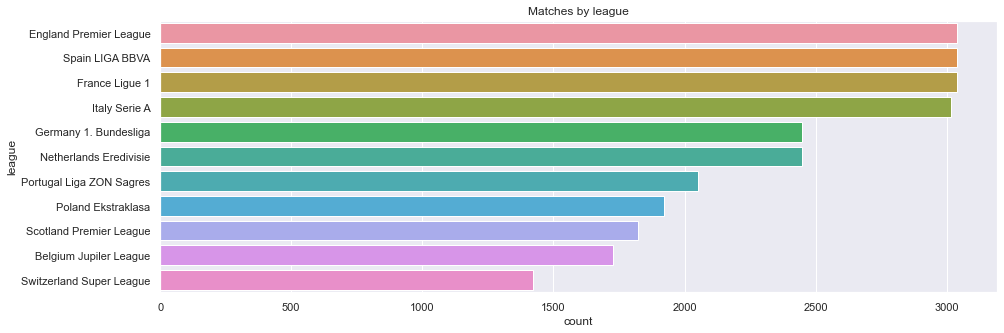

In [34]:
#plot total number of matches in each league
sns.set()
plt.figure(figsize=(15,5))
ax = sns.countplot(y = matches["league"],order=matches["league"].value_counts().index)
plt.title("Matches by league")
plt.show()

- most leagues have about 2000 matches played in 9 years

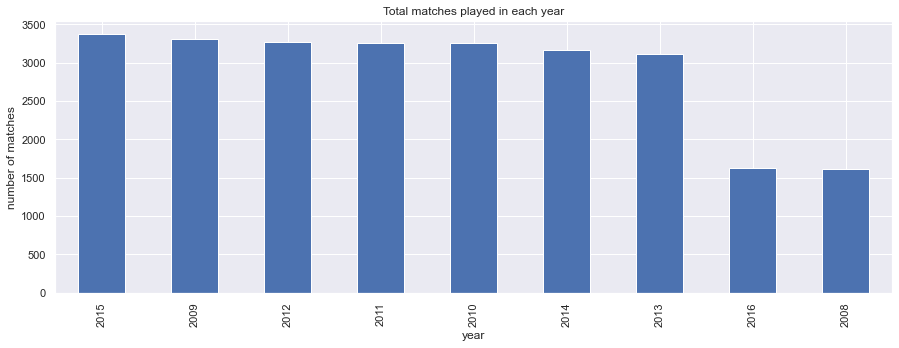

In [35]:
#plot total number of matches in each year
matches['year'].value_counts().plot(kind='bar',xlabel='year',ylabel='number of matches',figsize=(15,5),
                                   title='Total matches played in each year');

- number of matches played every year increase

#### 3.3 Who scores more Home team or away? is it affected by league?

<AxesSubplot:title={'center':'Total goal count in each league'}, xlabel='league', ylabel='goal count'>

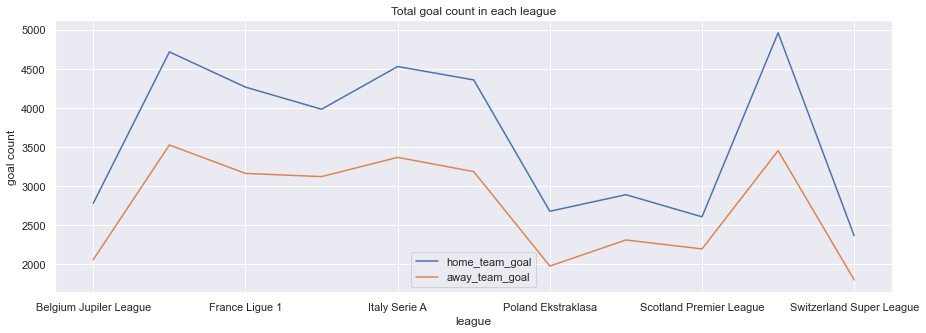

In [36]:
# calculate total goal in each league for home teams Vs away teams
matches.groupby(['league'])['home_team_goal','away_team_goal'].sum().plot(figsize=(15,5),ylabel='goal count',
                                                                         title='Total goal count in each league')

- home teams scores more goals than away teams in all league

#### 3.4  How does age affect rating? what is the average age of players?


Text(0, 0.5, 'number of players')

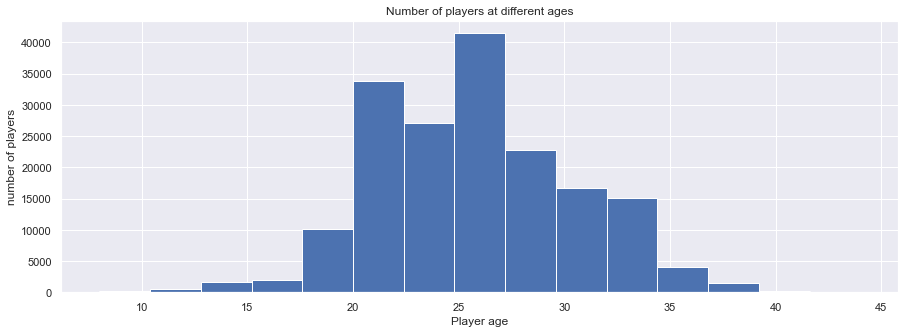

In [37]:
#plot total number of players at different ages
ax = players['age'].plot.hist(bins=15, title='Number of players at different ages',figsize=(15,5))
ax.set_xlabel('Player age')
ax.set_ylabel('number of players')

- Most players are between 20 and 30 year

<AxesSubplot:title={'center':'average rating by age'}, xlabel='player age', ylabel='overall rating'>

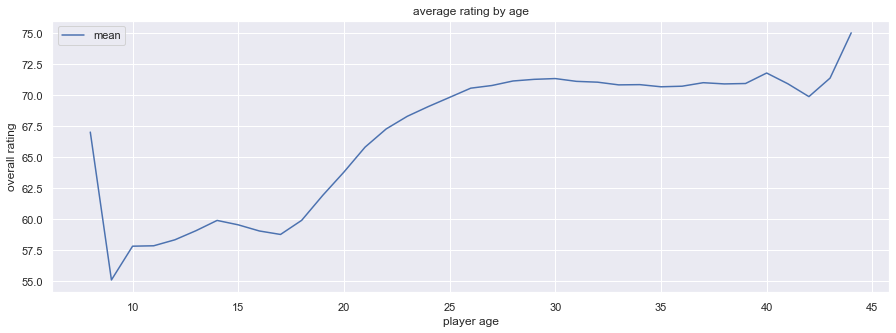

In [38]:
#plot relation between age and player overall rating
players.groupby('age')['overall_rating'].describe().plot(y='mean', ylabel='overall rating', xlabel='player age', use_index=True,
                                                                  figsize=(15,5), title='average rating by age')

- Player overall rating increase with  player age

<AxesSubplot:title={'center':'average rating over the years'}, xlabel='year', ylabel='overall rating'>

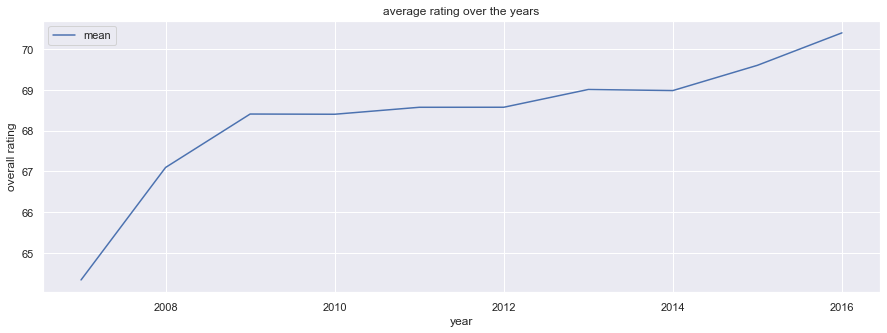

In [39]:
#plot sum of total rating given every year
players.groupby('year')['overall_rating'].describe().plot(y='mean', ylabel='overall rating', xlabel='year',
                                                          use_index=True, figsize=(15,5), title='average rating over the years')

- players overall ratings seams to be increased dramatically over the years

### 3.5 what makes a successful team?

- compare team attributes and create reltion between team performace and wins, we need first to create dataframe with data about top and bottom 10 teams.

In [40]:
#get teams with mos wins and teams with least wins
# compare team attribute for each group
matches.winner.value_counts().nsmallest(10)

Córdoba CF               3
AC Arles-Avignon         3
FC Dordrecht             4
SpVgg Greuther Fürth     4
DSC Arminia Bielefeld    4
Dunfermline Athletic     5
Trofense                 5
Feirense                 5
FC Penafiel              5
KAS Eupen                5
Name: winner, dtype: int64

In [41]:
matches.winner.value_counts().nlargest(11)

tie                  6596
FC Barcelona          234
Real Madrid CF        228
Celtic                218
FC Bayern Munich      193
Manchester United     192
Juventus              189
SL Benfica            185
FC Porto              183
Ajax                  181
FC Basel              180
Name: winner, dtype: int64

- create new dataframe filtered from teams dataframe 

In [42]:
#create dataframe with data of top  and bottom 10teams in 2015:
most_win = ['FC Barcelona', 'Real Madrid CF', 'Celtic', 'FC Bayern Munich','Manchester United', 'Juventus',
            'SL Benfica','FC Porto', 'Ajax', 'FC Basel']
least_win = ['AC Arles-Avignon', 'Córdoba CF', 'FC Dordrecht', 'SpVgg Greuther Fürth','DSC Arminia Bielefeld',
             'FC Dordrecht', 'FC Penafiel', 'Feirense','Dunfermline Athletic', 'KAS Eupen', 'Trofense']
df_m = teams[teams['team_name'].isin(most_win)]
df_m['stats']='most_wins'
df_l = teams[teams['team_name'].isin(least_win)]
df_l['stats']='least_wins'

#merge two dataframes
df = pd.concat([df_m, df_l], verify_integrity=True)


#### plot relevant team attribute grouped together
define a function to plot different team attributes 

In [43]:
#define a function to plot team attributes
def team_plot(att_1, att_2):
    atts = att_1 + '/' + att_2
    return df.groupby([att_1,att_2,'stats'])['team_name'].count().unstack('stats').plot(kind='barh',
                                                                                             rot=0,
                                                                                             width=0.8,
                                                                                             title='Top and Bottom 10 Teams by Attribute',
                                                                                             figsize=(14,8),
                                                                                             xlabel=atts)

- what is team positioning strategy for top and bottom teams

<AxesSubplot:title={'center':'Top and Bottom 10 Teams by Attribute'}, ylabel='positioning/chance_positioning'>

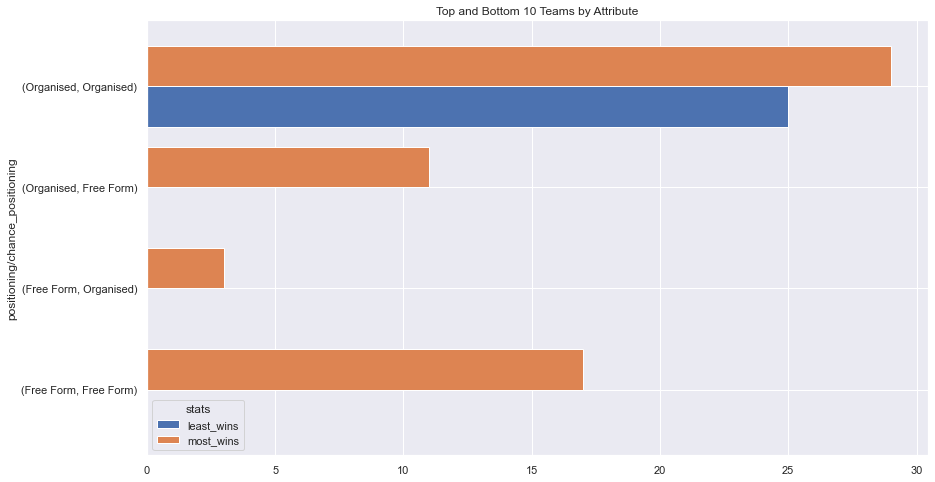

In [44]:
#plot teams against different attribute combinations:
team_plot('positioning','chance_positioning')

all bottom teams played with organized buildup play positioning and organized chance positioning, while top teams play strategy vary widely
- what is the defense strategy for top and bottom teams?

<AxesSubplot:title={'center':'Top and Bottom 10 Teams by Attribute'}, ylabel='defense_pressure/defender_line'>

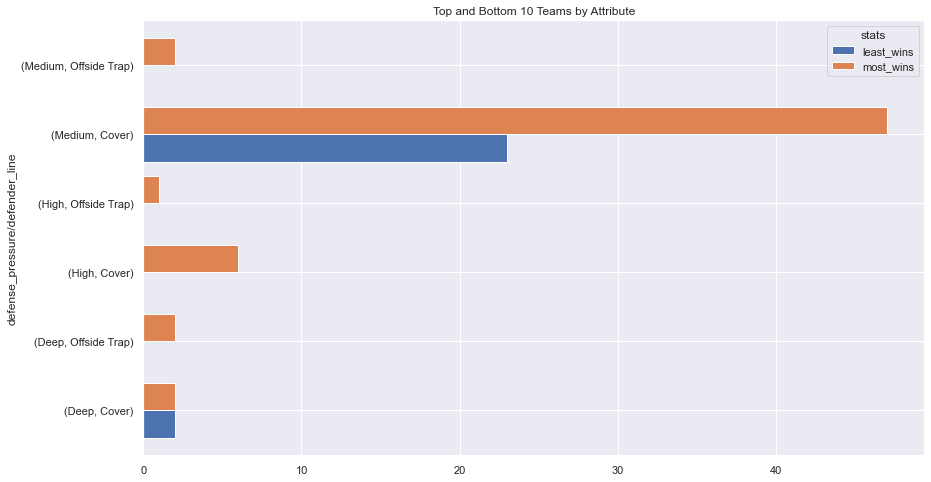

In [45]:
team_plot('defense_pressure','defender_line')

most top teams have similar defense strategy (medium defense pressure, wide defender ine)

### compare buildup play attributes

<AxesSubplot:title={'center':'Top and Bottom 10 Teams by Attribute'}, ylabel='passing/dribbling'>

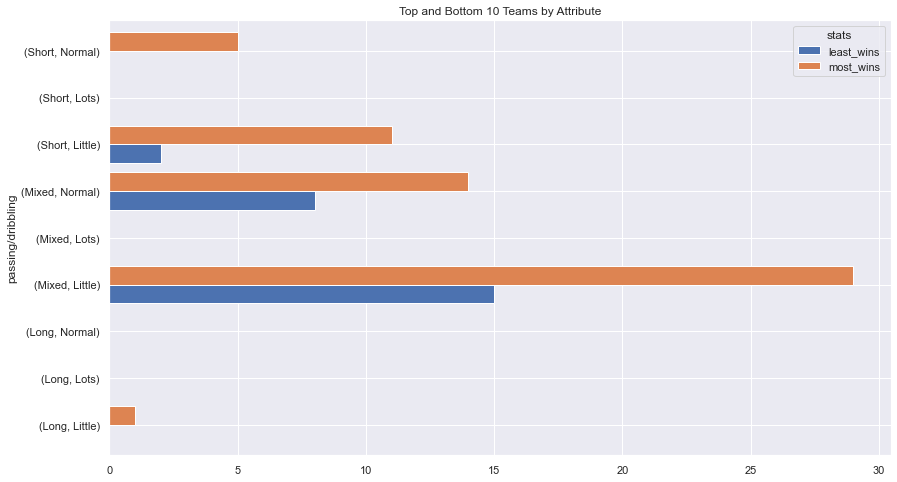

In [46]:
team_plot('passing','dribbling')

- All bottom teams have mixed passing and little to normal dribbling while Top teams perform more short passing and more dribbling

<a id='conclusions'></a>
## Conclusions

- Most top teams have similar defense strategy (medium defense pressure, wide defender ine)
- All bottom teams played with organized buildup play positioning and organized chance positioning, while top teams play strategy vary widely
- All bottom teams have mixed passing and little to normal dribbling while Top teams perform more short passing and more dribbling
- Player overall rating increase with age
- Most players are between 20 and 30 year
- home teams scores more goals than away teams in all league
- players ratings seams to be increased dramatically over the years
- teams with most wins are playing in league with more matchers per season
- player attributes that mostly affect overall rating are: reactions, potential, short_passing, ball_control, long_passing, vision ,shot_power 

## Limitations

>Database contains alot of outliers

>This dataset does not contains data for all matches. (sample data) There could have been different number of samples available for a team's matches played at home and away.

>Recent players ratings are way higher than old rating with no corresponding raise in players overall attributes, which affect all players attribute analysis